In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import time
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [7]:
# Sigmoid function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# Generate w* and normalize it
def generate_w_star():
  w_star = np.random.randn(10)
  return w_star / np.linalg.norm(w_star)

# Generate the training set
def generate_data(m, w_star):
  X = np.random.randn(m, 10)
  y = np.zeros(m)
  for i in range(m):
    prob = sigmoid(np.dot(w_star, X[i]))
    y[i] = 1 if np.random.uniform(0, 1) <= prob else 0
  return X, y

# Generate the test set
train_X, train_y = generate_data(1000, generate_w_star())
print(train_X)
print(train_y)

[[ 1.85078702 -1.01432247  1.07183875 ... -1.6038112  -0.0877569
   0.17797024]
 [ 1.63782687  0.33080514 -0.36246578 ...  0.33570331 -0.11687339
  -1.07740393]
 [-0.48110386 -0.8141957  -0.44491661 ... -1.38326358 -0.3070104
  -1.16945444]
 ...
 [-0.60242371  0.82413963 -0.46385129 ... -1.01919027  0.13366982
   0.85295461]
 [-0.52264833 -0.33429748  0.20737218 ...  0.66782548  1.31222534
   0.65931286]
 [ 2.49279788 -0.46637893 -0.74469685 ... -2.04083396 -0.5767428
  -1.83731078]]
[1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.


## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [15]:
def logistic_regression(X, y):
  clf = LogisticRegression(max_iter=1000)
  clf.fit(X, y)
  return clf.coef_.flatten()

logistic_reg_weight_vector = logistic_regression(train_X, train_y)
print(logistic_reg_weight_vector)

[ 0.47672476  0.30395147 -0.04516602  0.51806999 -0.22085707 -0.04611519
 -0.31236607 -0.38448447  0.10465814  0.24541963]


## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

In [10]:
def gradient_descent(X, y, lr=0.01, iterations=1000):
  m, n = X.shape
  w = np.random.randn(n)
  for _ in range(iterations):
    # Compute the predictions using the sigmoid function
    predictions = sigmoid(np.dot(X, w))

    # Compute the error (difference between predicted probabilities and true labels)
    error = predictions - y

    # Compute the gradient of the new loss function
    gradient = np.dot(X.T, error * predictions * (1 - predictions)) / m

    # Update the weights using the learning rate and the gradient
    w -= lr * gradient
  return w

gradient_descent_weight_vector = gradient_descent(train_X, train_y)
print(gradient_descent_weight_vector)

[-2.55391844  0.37042121  1.5159639   0.03149782 -1.60416362  0.13438096
 -1.74436293 -0.93464549  0.94202428 -0.77960027]


## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [12]:
def stochastic_gradient_descent(X, y, lr=0.01, iterations=1000):
  m, n = X.shape
  w = np.random.randn(n)
  for _ in range(iterations):
    i = np.random.randint(m)  # Randomly select an index for one training example

    # Compute the prediction for the randomly selected example
    prediction = sigmoid(np.dot(X[i], w))

    # Compute the error
    error = prediction - y[i]

    # Compute the gradient of the new loss function
    gradient = error * prediction * (1 - prediction) * X[i]

    # Update the weights using the learning rate and the gradient
    w -= lr * gradient
  return w

stochastic_gradient_descent_weight_vector = stochastic_gradient_descent(train_X, train_y)
print(stochastic_gradient_descent_weight_vector)


[-0.42315908 -0.65896606  0.67142017  0.07341845  0.08957614 -0.11819917
  0.33573917 -0.19926333 -0.37277966 -0.88366404]


## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w -
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

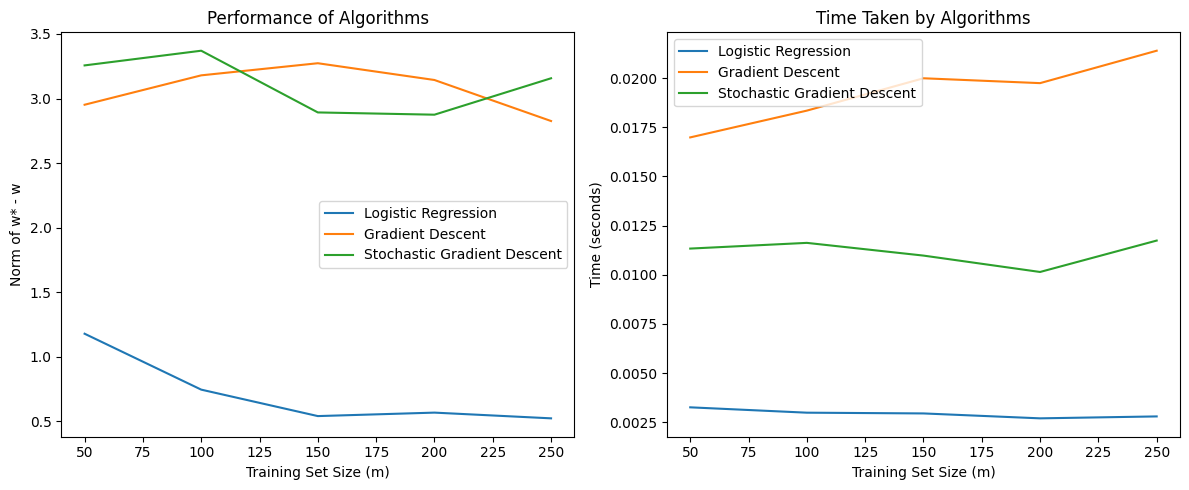

In [16]:
def measure_performance(m_values):
  results = {'logistic': [], 'gd': [], 'sgd': [], 'time_logistic': [], 'time_gd': [], 'time_sgd': []}

  for m in m_values:
    logistic_norms, gd_norms, sgd_norms = [], [], []
    logistic_times, gd_times, sgd_times = [], [], []

    for _ in range(10):
      w_star = generate_w_star()
      X, y = generate_data(m, w_star)

      # Logistic Regression
      start = time.time()
      w_logistic = logistic_regression(X, y)
      logistic_times.append(time.time() - start)
      logistic_norms.append(np.linalg.norm(w_star - w_logistic))

      # Gradient Descent
      start = time.time()
      w_gd = gradient_descent(X, y)
      gd_times.append(time.time() - start)
      gd_norms.append(np.linalg.norm(w_star - w_gd))

      # Stochastic Gradient Descent
      start = time.time()
      w_sgd = stochastic_gradient_descent(X, y)
      sgd_times.append(time.time() - start)
      sgd_norms.append(np.linalg.norm(w_star - w_sgd))

    results['logistic'].append(np.mean(logistic_norms))
    results['gd'].append(np.mean(gd_norms))
    results['sgd'].append(np.mean(sgd_norms))
    results['time_logistic'].append(np.mean(logistic_times))
    results['time_gd'].append(np.mean(gd_times))
    results['time_sgd'].append(np.mean(sgd_times))

  return results

# Plotting the results
m_values = [50, 100, 150, 200, 250]
results = measure_performance(m_values)

plt.figure(figsize=(12, 5))

# Plotting the performance
plt.subplot(1, 2, 1)
plt.plot(m_values, results['logistic'], label='Logistic Regression')
plt.plot(m_values, results['gd'], label='Gradient Descent')
plt.plot(m_values, results['sgd'], label='Stochastic Gradient Descent')
plt.xlabel('Training Set Size (m)')
plt.ylabel('Norm of w* - w')
plt.title('Performance of Algorithms')
plt.legend()

# Plotting the time taken
plt.subplot(1, 2, 2)
plt.plot(m_values, results['time_logistic'], label='Logistic Regression')
plt.plot(m_values, results['time_gd'], label='Gradient Descent')
plt.plot(m_values, results['time_sgd'], label='Stochastic Gradient Descent')
plt.xlabel('Training Set Size (m)')
plt.ylabel('Time (seconds)')
plt.title('Time Taken by Algorithms')
plt.legend()

plt.tight_layout()
plt.show()

# Problem 2

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

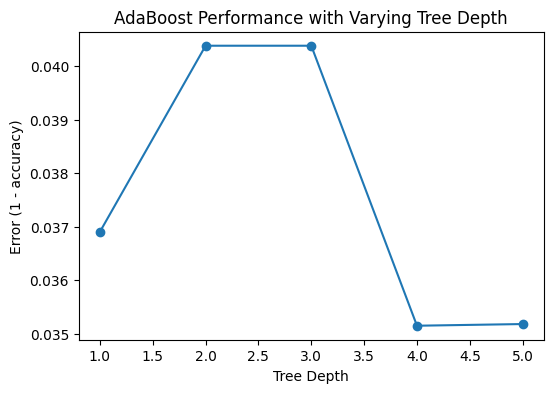

In [20]:
cancer = datasets.load_breast_cancer()

X, y = cancer.data, cancer.target

# Set up the depths and results list
depths = [1, 2, 3, 4, 5]
errors = []

# Train AdaBoost with different depths
for depth in depths:
  clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=depth))
  scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
  errors.append(1 - scores.mean())

# Plot the error vs depth
plt.figure(figsize=(6, 4))
plt.plot(depths, errors, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Error (1 - accuracy)')
plt.title('AdaBoost Performance with Varying Tree Depth')
plt.show()